In [1]:
from datetime import date
from dateutil.parser import parse
import email
import matplotlib.image as mpimg
import networkx as nx
import numpy as np
import os
import re
import sys
import os

In [2]:
import mailbox

# Constants to change
PROJECT_PATH = 'enron'

DIRNAME = os.path.dirname(os.getcwd())+os.sep+PROJECT_PATH+os.sep
MBOX_PATH = DIRNAME+'enron.mbox'
DATA = DIRNAME+'maildir'+os.sep
SAMPLE = DIRNAME+'sample'+os.sep+'1'+os.sep
MBOX = mailbox.mbox(MBOX_PATH)

In [4]:
def maildir_to_mbox():
    with open(MBOX_PATH, 'w') as mbox:   
        for (root, dirs, file_names) in os.walk(DATA):
            if root.split(os.sep)[-1].lower() != 'inbox':
                continue

            # Process each message in 'inbox'
            for file_name in file_names:
                file_path = os.path.join(root, file_name)
                message_text = open(file_path).read()
                msg = email.message_from_string(message_text)
                mbox.write(msg.as_string(unixfrom=True) + "\n\n")

    return mbox

In [5]:
maildir_to_mbox()

<_io.TextIOWrapper name='c:\\Users\\utilisateur\\Desktop\\Projets\\enron\\enron.mbox' mode='w' encoding='cp1252'>

In [6]:
"""Sample creation."""
import os
import random
import shutil
import numpy


def create_sample(sample_size, number_of_sample):
    """Create a sample of emails among all the emails."""
    print(f"Creation of {number_of_sample} samples each contening {sample_size} emails.")

# Definition of the different directories.

    dirname = os.getcwd()
    mailDir = os.path.join(dirname, 'maildir')

# Counting emails.

    mails_count = sum(len(files) for _, _, files in os.walk(mailDir))
    print(f"The maildir folder contains {mails_count} emails.")

# Cleaning the target file.

    shutil.rmtree(os.path.join(dirname, 'sample'))

    for sample in range(1, number_of_sample+1):
        print(f"Sample number {sample}.")
        sampleDir = os.path.join(dirname, 'sample', str(sample))

        if not os.path.exists(sampleDir):
            os.makedirs(sampleDir)

        # Draw random emails and copy them to the sample folder.
        random_list = numpy.random.randint(1, mails_count+1, sample_size)
        print(len(random_list))
        id_mail = 1
        for repertory, sub_repertory, files in os.walk(mailDir):
            for f in files:
                if id_mail in random_list:
                    shutil.copy(os.path.join(repertory, f), sampleDir)
                    os.rename(os.path.join(sampleDir, f), os.path.join(
                        sampleDir, str(id_mail)))
                id_mail += 1
        print(f"Creation of the sample {sample} successfully completed.")
        print(
            f"{sample_size} random mails have been copied to target repertory."
            )

    print(
        f"OK - {number_of_sample} samples of {sample_size} emails created in "
        "target repertory.")


create_sample(10000, 1)

Creation of 1 samples each contening 10000 emails.
The maildir folder contains 517402 emails.
Sample number 1.
10000
Creation of the sample 1 successfully completed.
10000 random mails have been copied to target repertory.
OK - 1 samples of 10000 emails created in target repertory.


In [9]:
def sample_to_mbox():
    with open(MBOX, 'w') as mbox:   
        for (root, dirs, file_names) in os.walk(SAMPLE):
            # Process each message 
            for file_name in file_names:
                file_path = os.path.join(root, file_name)
                message_text = open(file_path).read()
                msg = email.message_from_string(message_text)
                mbox.write(msg.as_string(unixfrom=True) + "\n\n")

    return mbox

In [10]:
sample_to_mbox()

TypeError: expected str, bytes or os.PathLike object, not mbox

In [11]:
def data_cleaning(df):
    """Clean the dataframe.

    Args:
        df (dict): dictionnary to clean

    Returns:
        dict: Enron corpus cleaned dataframe

    """
    cols_to_keep = ['Date', 'From', 'To', 'Cc', 'Bcc', 'Subject', 'Body']
    df = df[cols_to_keep]

    df = df.drop_duplicates()
    df = df.drop_duplicates(subset=['Date', 'From', 'To'])
    df.dropna(subset = ["Date"], inplace=True)

    return df

In [12]:
import pandas as pd

def mbox_to_df():
    """Convert the mailbox to a dataframe.

    Returns:
        dict: Enron corpus sample dataframe

    """
    mbox_dict = {}

    for i, msg in enumerate(MBOX):
        mbox_dict[i] = {}
        for header in msg.keys():
            mbox_dict[i][header] = msg[header]

        mbox_dict[i]['Body'] = msg.get_payload().replace('\n', ' ').replace('\t', ' ').strip()

    df = pd.DataFrame.from_dict(mbox_dict, orient='index')
    df = data_cleaning(df)
    df['Date'] = pd.to_datetime(df['Date'])

    df.to_csv('sample.csv', sep='|')

    return df

In [13]:
df = mbox_to_df()

In [ ]:
# OR
import pandas as pd

# Complete dataframe
df = pd.read_csv('emails.csv', sep='|')

In [27]:
# OR
import pandas as pd

# Sampled dataframe
df = pd.read_csv('sample.csv', sep='|')

In [30]:
import pandas as pd

df['Date'] = pd.to_datetime(df['Date'], utc=True)
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.dayofweek

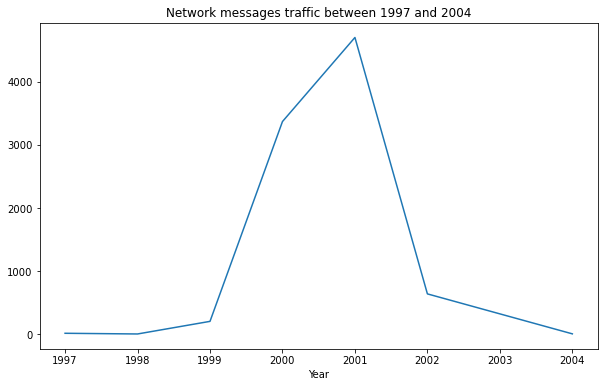

In [23]:
import matplotlib.pyplot as plt

# reduce the sample period
# looks like the total number of emails really ramped up in 2000 and 2001
indices = (df['Year'] >= 1997) & (df['Year'] <= 2004)
plt.figure(figsize = (10,6))
figure1 = df.loc[indices].groupby('Year')['Body'].count().plot(title='Network messages traffic between 1997 and 2004')

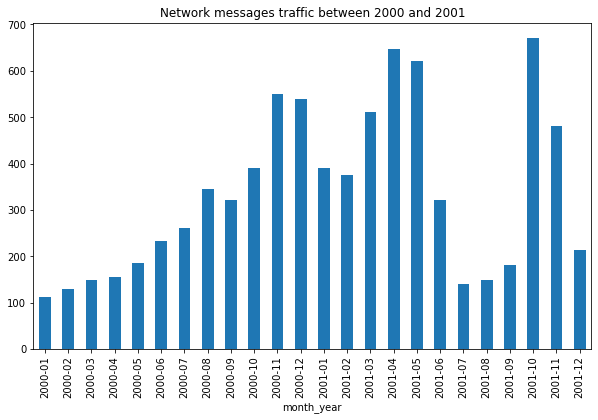

In [24]:
# reduce the sample period
# looks like the total number of emails really ramped up in october 2001 (date of bankruptcy)
indices = (df['Year'] >= 2000) & (df['Year'] <= 2001)
plt.figure(figsize = (10,6))
df['month_year'] = pd.to_datetime(df['Date'], utc=True).dt.to_period('M')
figure2 = df.loc[indices].groupby('month_year')['Body'].count().plot(kind='bar', title='Network messages traffic between 2000 and 2001')

In [31]:
df = df[(df['Year'] >= 2000) & (df['Year'] <= 2001)]

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans

stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com'])
vectorizer = TfidfVectorizer(stop_words=stopwords)

# Keep only body message
cols_to_keep = ['Body']
df = df[cols_to_keep]

X = vectorizer.fit_transform(df['Body'].values.astype(str))
terms = vectorizer.get_feature_names()

model = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]

In [33]:
for i in range(3):
    print('Cluster ', i)
    for ind in order_centroids[i, :100]:
        print(terms[ind])
    
    print()

Cluster  0
thanks
attached
enron
know
let
http
time
need
mail
713
new
00
2001
questions
meeting
message
energy
power
gas
like
just
information
www
sent
final
today
email
day
week
01
deal
file
list
doc
schedule
image
10
market
agreement
going
30
make
don
thank
ll
date
want
office
report
group
california
work
think
send
good
contact
subject
company
original
friday
houston
mark
monday
hour
business
price
jeff
2000
schedules
11
help
iso
october
review
did
number
comments
tomorrow
following
year
said
click
use
forward
credit
working
000
mike
november
changes
available
deals
start
trading
john
free
fax
received
853
copy

Cluster  1
enron
na
corp
ees
713
enronxgate
et
1400
77002
3490
smith
646
perlingiere
eb
america
debra
north
communications
street
texas
fax
853
3885
7658
2001
houston
enron_development
sara
dperlin
pm
cc
shackleton
subject
phone
2000
legal
mary
forwarded
03
department
05
04
lon
mark
jeff
12
02
01
attached
10
09
11
richard
john
steven
kean
james
meeting
susan
thanks
david
ste

In [34]:
print()
print('Prediction')
email_to_test = 'Enter email here'
X3 = vectorizer.transform([email_to_test])
predicted = model.predict(X3)
print(predicted)


Prediction
[0]


In [39]:
import csv
import pandas as pd


def wordFromCSV(src, word):
    """Create a dataframe of the mails containing the target word.
    
    Args:
        src(csv): source of mails to explore.
        word(str): target word to find.

    Returns:
        df:dataframe
    """
    csv.field_size_limit(100000000)
    data=[]
    target=word.lower()

    with open(src, 'r') as csvfile:
        mails = csv.reader(csvfile, delimiter='|')
        for message in mails:
            body_message=message[7].lower()
            if body_message.__contains__(target)==True:
                temp=[
                    message[1],
                    message[2],
                    message[3],
                    message[4],
                    message[5],
                    message[6],
                    message[7]]
                    
                data.append(temp)
                df = pd.DataFrame(data, columns=['Date',  'From',  'To', 'Cc',  'Bcc',  'Subject', 'Body']) 

    return df

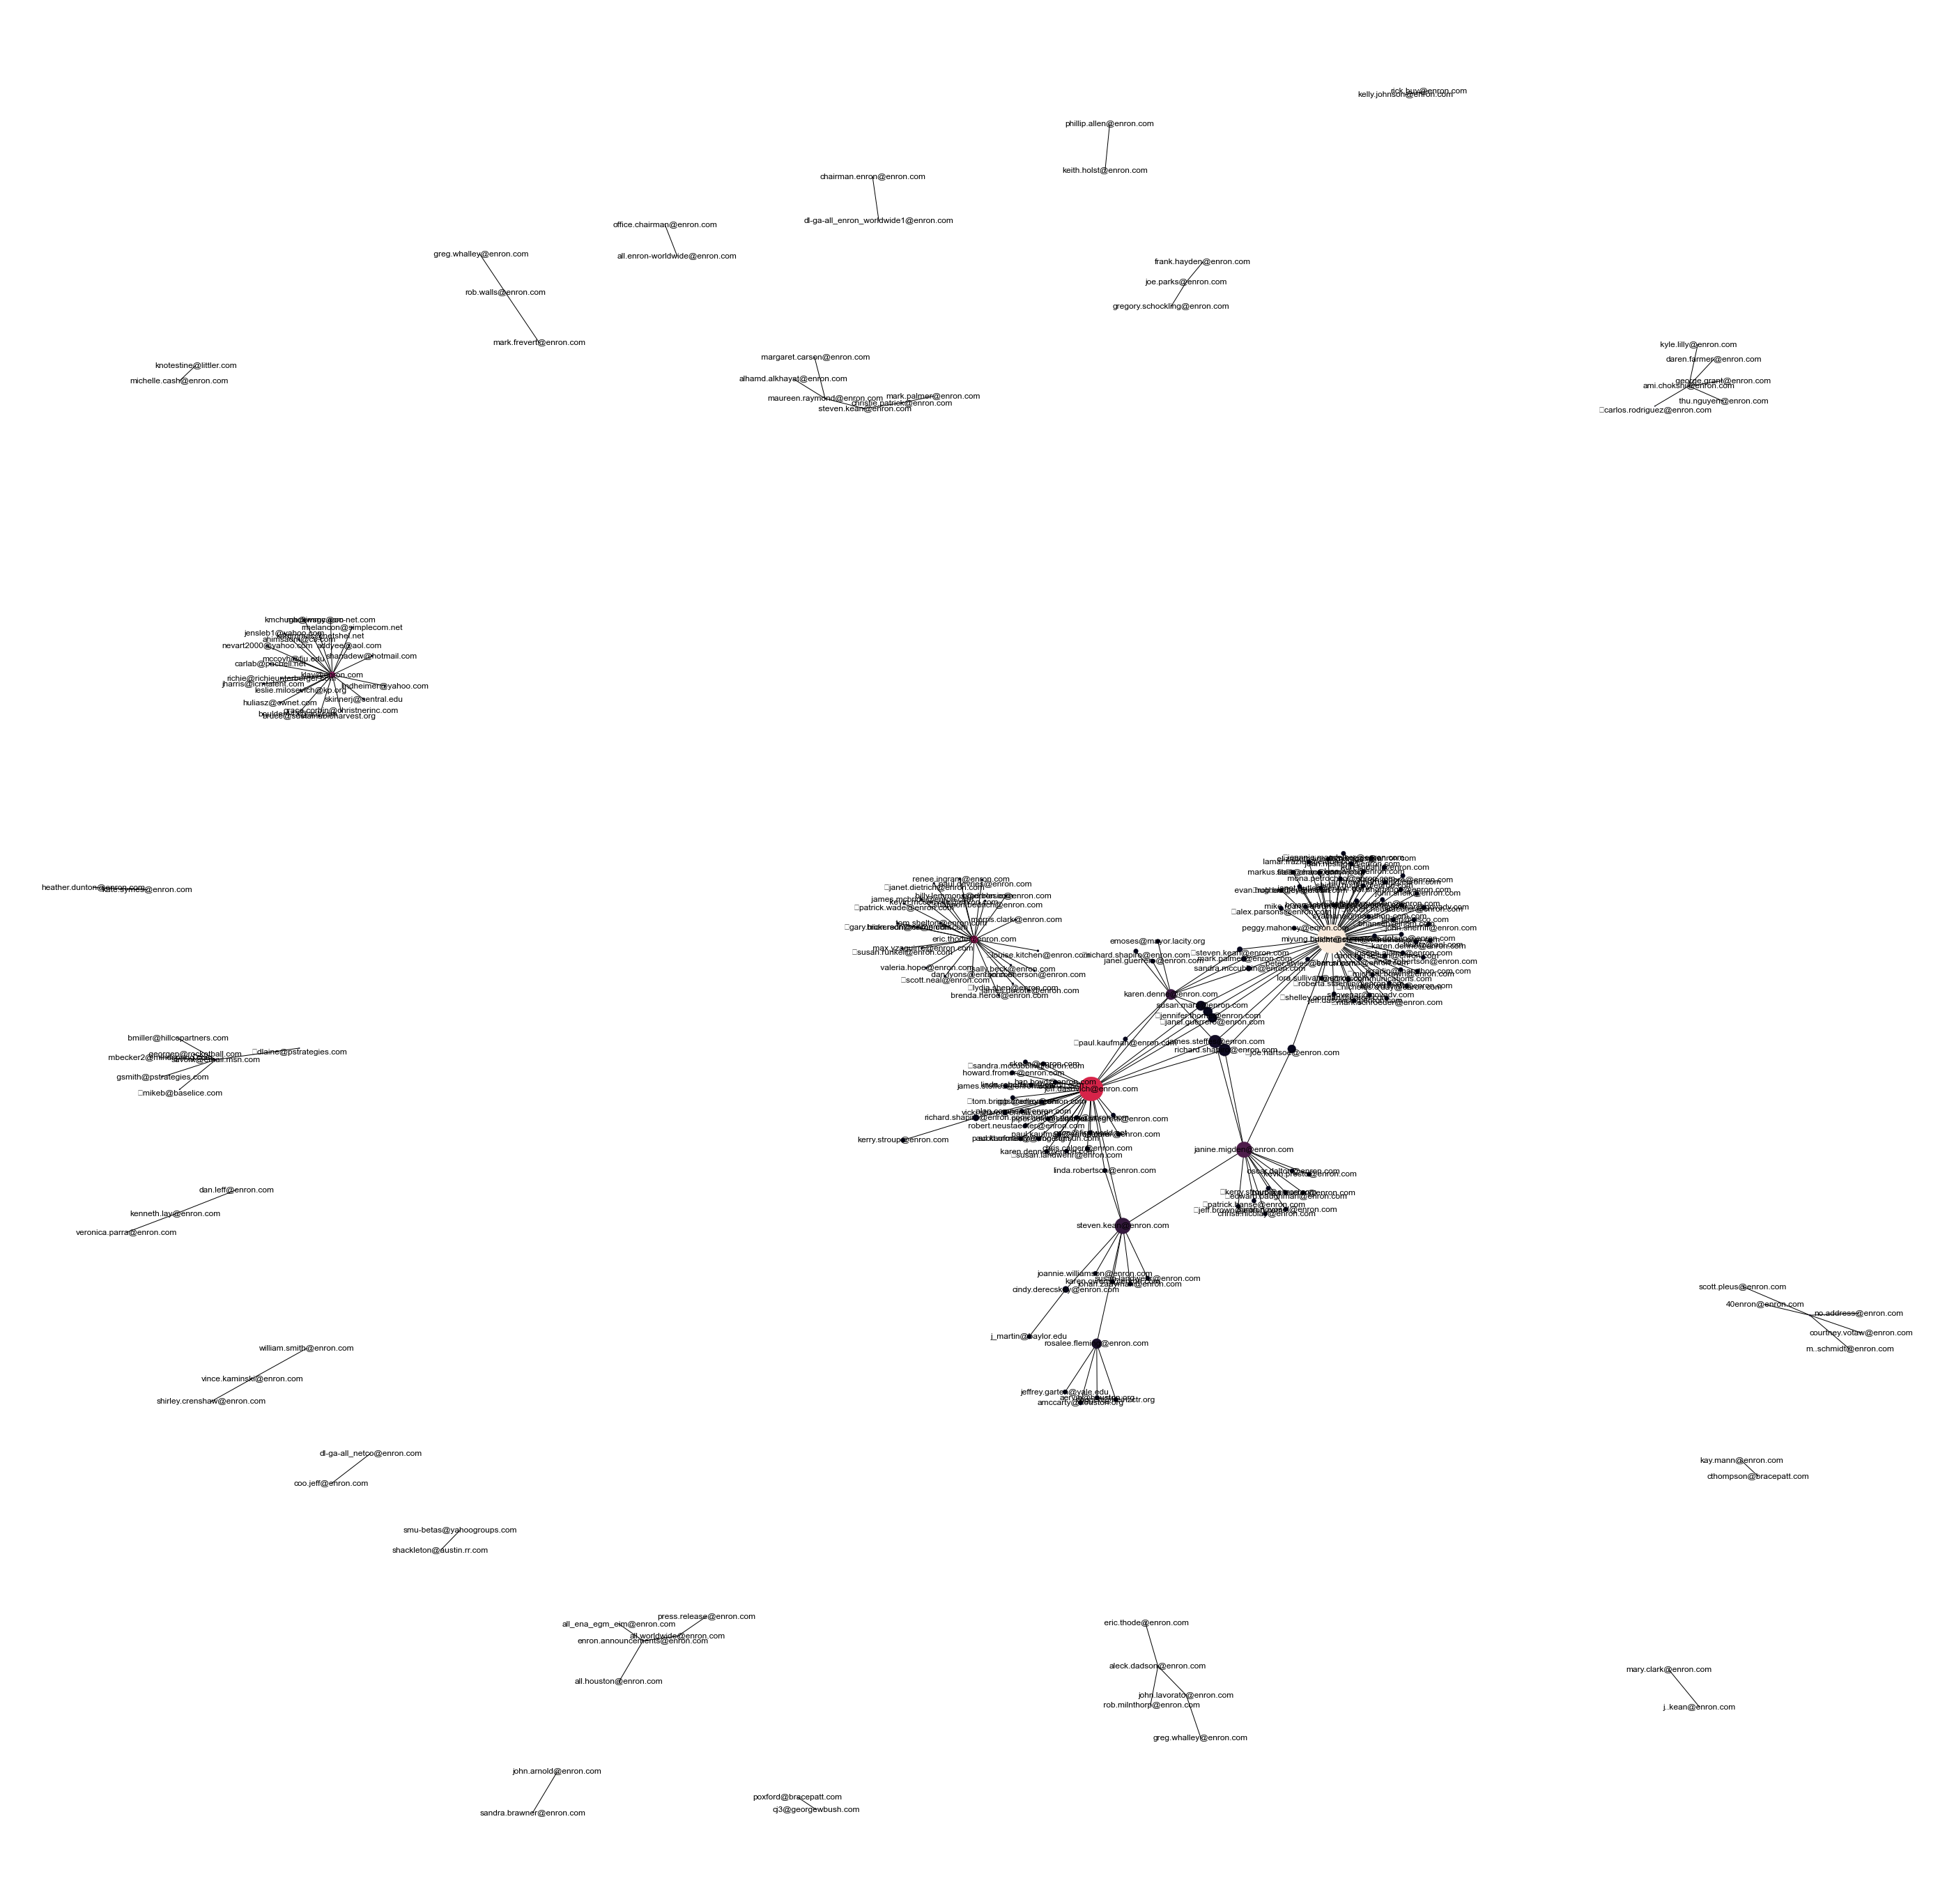

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

#Create the graph
G_symmetric = nx.Graph()

graph_df = wordFromCSV('sample.csv', 'ken lay')

for index, mail in graph_df.iterrows():
    mail_to=mail[2].split(sep=",")

    for adress in mail_to:
        # --- Tester si le node existe et si il existe ajouter +1 au weight
        G_symmetric.add_edge(mail[1],adress,weight=1)

pos = nx.spring_layout(G_symmetric)
betCent = nx.betweenness_centrality(G_symmetric, normalized=True, endpoints=True)
node_color = [20000.0 * G_symmetric.degree(v) for v in G_symmetric]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(50, 50))
nx.draw_networkx(G_symmetric, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size )

In [40]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures
import nltk
nltk.download('stopwords')

csv.field_size_limit(100000000)

with open('sample.csv', 'r') as csvfile :
    mail = csv.reader(csvfile, delimiter='|')
    tokens=''
    for message in mail:
        tokens=tokens + message[6]

tokenizer = nltk.RegexpTokenizer(r"[a-zA-Z]{3,}")
tokenized_messages = [t.lower() for t in tokenizer.tokenize(tokens)]
stopwords = nltk.corpus.stopwords.words('english')
filtered_tokenized_messages = [word for word in tokenized_messages if word not in stopwords]
without_words=['hour', 'codesite', 'hourahead', 'date', 'request', 'access', 'start']
filtered_tokenized_messages = [word for word in filtered_tokenized_messages if word not in without_words]
fdist = FreqDist(filtered_tokenized_messages)
common = fdist.most_common(100)
print(fdist)
print(common)

trigram_collocation = TrigramCollocationFinder.from_words(filtered_tokenized_messages)
trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 100)


import pandas_profiling

df = wordFromCSV('sample.csv', 'work')
print("Le fichier a " + str(df.shape[0]) + " lignes et " + str(df.shape[1]) + " colonnes")

pandas_profiling.ProfileReport(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<FreqDist with 10101 samples and 24125 outcomes>
[('enron', 273), ('energy', 172), ('gas', 147), ('power', 146), ('new', 146), ('meeting', 136), ('report', 108), ('conference', 91), ('com', 90), ('credit', 82), ('deal', 77), ('trading', 72), ('daily', 69), ('eol', 67), ('agreementre', 64), ('call', 63), ('update', 62), ('market', 59), ('day', 58), ('schedule', 58), ('agreement', 54), ('letter', 52), ('contract', 49), ('may', 48), ('october', 48), ('inc', 47), ('notification', 47), ('california', 47), ('meetingre', 46), ('change', 46), ('ferc', 46), ('time', 45), ('news', 45), ('fwd', 45), ('draft', 44), ('management', 44), ('today', 44), ('june', 43), ('master', 43), ('lay', 42), ('legal', 42), ('ena', 41), ('weekly', 41), ('isda', 41), ('west', 41), ('price', 41), ('december', 40), ('revised', 40), ('risk', 40), ('please'